In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn import tree

In [ ]:
#for files in glob.glob("/content/gdrive/My Drive/NIST/*.csv"):
  #print (files)
df = pd.concat([pd.read_csv(files) for files in glob.glob("/content/gdrive/My Drive/NIST/*.csv")])
df


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266331,5.63209e+07,139.3,56320958,56320761,112641719,5.63209e+07,139.3,56320958,56320761,0,0,0,0,0,0,0,0,0,0,0,0.0266331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63209e+07,139.3,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266332,5.63207e+07,114.551,56320814,56320652,112641466,5.63207e+07,114.551,56320814,56320652,0,0,0,0,0,0,0,0,0,0,0,0.0266332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63207e+07,114.551,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266338,5.63193e+07,301.935,56319525,56319098,112638623,5.63193e+07,301.935,56319525,56319098,0,0,0,0,0,0,0,0,0,0,0,0.0266338,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63193e+07,301.935,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,82.6,196.741,976,0,227.3,371.678,544.162,3.87359,268915,247444,673900,22,6453966,460998,123109,673900,229740,5637902,626434,455082,1167293,554,0,0,0,0,488,328,2.32415,1.54943,0,976,135.077,277.835,77192.2,0,0,0,1,0,0,0,0,0,140.48,82.6,227.3,0,0,0,0,0,0,15,1239,10,2273,65535,233,6,32,0,0,0,0,0,0,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,81.6429,203.746,976,0,200.818,362.25,380.733,2.8396,366836,511357,1928102,21,8804066,677236,532417,1928102,246924,7715481,771548,755543,2174893,90,0,0,0,0,456,360,1.59017,1.24942,0,976,128.923,279.763,78267.4,0,0,0,1,0,0,0,0,0,134.08,81.6429,200.818,0,0,0,0,0,0,14,1143,11,2209,5808,233,6,32,0,0,0,0,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613099,23,6,28/02/2018 11:59:12,3,1,1,0,0,0,0,0,0,0,0,0,0,0,666666.6667,3,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,20,333333.3333,333333.3333,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1024,0,0,24,0,0,0,0,0,0,0,0,Infilteration
613100,425,6,28/02/2018 10:50:04,2,1,1,0,0,0,0,0,0,0,0,0,0,0,1000000,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,20,500000,500000,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1024,0,0,24,0,0,0,0,0,0,0,0,Infilteration
613101,445,6,28/02/2018 12:52:55,732728,2,2,0,0,0,0,0,0,0,0,0,0,0,5.459051654,244242.6667,422996.5408,732677,20,732697,732697,0,732697,732697,732708,732708,0,732708,732708,0,0,0,0,64,40,2.729525827,2.729525827,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,2,0,8192,0,0,32,0,0,0,0,0,0,0,0,Benign
613102,23,6,28/02/2018 11:10:50,22,1,1,0,0,0,0,0,0,0,0,0,0,0,90909.09091,22,0,22,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,20,45454.54545,45454.54545,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,

In [ ]:
# Convert to binary classes


df['Label'] = df['Label'].replace(['FTP-BruteForce','SSH-Bruteforce','Infilteration','DDOS attack-HOIC','DDOS attack-LOIC-UDP'],'Botnet')
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266331,5.63209e+07,139.3,56320958,56320761,112641719,5.63209e+07,139.3,56320958,56320761,0,0,0,0,0,0,0,0,0,0,0,0.0266331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63209e+07,139.3,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266332,5.63207e+07,114.551,56320814,56320652,112641466,5.63207e+07,114.551,56320814,56320652,0,0,0,0,0,0,0,0,0,0,0,0.0266332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63207e+07,114.551,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266338,5.63193e+07,301.935,56319525,56319098,112638623,5.63193e+07,301.935,56319525,56319098,0,0,0,0,0,0,0,0,0,0,0,0.0266338,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63193e+07,301.935,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,82.6,196.741,976,0,227.3,371.678,544.162,3.87359,268915,247444,673900,22,6453966,460998,123109,673900,229740,5637902,626434,455082,1167293,554,0,0,0,0,488,328,2.32415,1.54943,0,976,135.077,277.835,77192.2,0,0,0,1,0,0,0,0,0,140.48,82.6,227.3,0,0,0,0,0,0,15,1239,10,2273,65535,233,6,32,0,0,0,0,0,0,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,81.6429,203.746,976,0,200.818,362.25,380.733,2.8396,366836,511357,1928102,21,8804066,677236,532417,1928102,246924,7715481,771548,755543,2174893,90,0,0,0,0,456,360,1.59017,1.24942,0,976,128.923,279.763,78267.4,0,0,0,1,0,0,0,0,0,134.08,81.6429,200.818,0,0,0,0,0,0,14,1143,11,2209,5808,233,6,32,0,0,0,0,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613099,23,6,28/02/2018 11:59:12,3,1,1,0,0,0,0,0,0,0,0,0,0,0,666666.6667,3,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,20,333333.3333,333333.3333,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1024,0,0,24,0,0,0,0,0,0,0,0,Botnet
613100,425,6,28/02/2018 10:50:04,2,1,1,0,0,0,0,0,0,0,0,0,0,0,1000000,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,20,500000,500000,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1024,0,0,24,0,0,0,0,0,0,0,0,Botnet
613101,445,6,28/02/2018 12:52:55,732728,2,2,0,0,0,0,0,0,0,0,0,0,0,5.459051654,244242.6667,422996.5408,732677,20,732697,732697,0,732697,732697,732708,732708,0,732708,732708,0,0,0,0,64,40,2.729525827,2.729525827,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,2,0,8192,0,0,32,0,0,0,0,0,0,0,0,Benign
613102,23,6,28/02/2018 11:10:50,22,1,1,0,0,0,0,0,0,0,0,0,0,0,90909.09091,22,0,22,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,20,45454.54545,45454.54545,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,

In [ ]:
#df.info()
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors = 'coerce') #errors = 'coerce'

In [ ]:
#convert the hour in timestamp to one hot encodings 
#to_one_hot = raw.date_time.dt.day_name()
to_one_hot = df.Timestamp.dt.hour
# second: one hot encode to 7 columns
hours = pd.get_dummies(to_one_hot)

In [ ]:
df_new = pd.concat([df,hours],axis=1, sort=False)
#df_new = df_new.drop("Label", axis = 1)
df_new = df_new.drop("Timestamp", axis = 1)
df_new = df_new.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [ ]:
df_new

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,...,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,1.0,2.0,3.0,4.0,5.0,7.0,8.0,9.0,10.0,11.0,12.0
0,0,0,112641719,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266331,5.63209e+07,139.3,56320958,56320761,112641719,5.63209e+07,139.3,56320958,56320761,0,0,0,0,0,0,0,0,0,0,0,0.0266331,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63209e+07,139.3,56320958,56320761,Benign,0,0,0,0,0,0,1,0,0,0,0
1,0,0,112641466,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266332,5.63207e+07,114.551,56320814,56320652,112641466,5.63207e+07,114.551,56320814,56320652,0,0,0,0,0,0,0,0,0,0,0,0.0266332,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63207e+07,114.551,56320814,56320652,Benign,0,0,0,0,0,0,1,0,0,0,0
2,0,0,112638623,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0266338,5.63193e+07,301.935,56319525,56319098,112638623,5.63193e+07,301.935,56319525,56319098,0,0,0,0,0,0,0,0,0,0,0,0.0266338,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0,0,0,0,5.63193e+07,301.935,56319525,56319098,Benign,0,0,0,0,0,0,1,0,0,0,0
3,22,6,6453966,15,10,1239,2273,744,0,82.6,196.741,976,0,227.3,371.678,544.162,3.87359,268915,247444,673900,22,6453966,460998,123109,673900,229740,5637902,626434,455082,1167293,554,0,0,0,0,488,328,2.32415,1.54943,0,...,0,0,0,140.48,82.6,227.3,0,0,0,0,0,0,15,1239,10,2273,65535,233,6,32,0,0,0,0,0,0,0,0,Benign,0,0,0,0,0,0,1,0,0,0,0
4,22,6,8804066,14,11,1143,2209,744,0,81.6429,203.746,976,0,200.818,362.25,380.733,2.8396,366836,511357,1928102,21,8804066,677236,532417,1928102,246924,7715481,771548,755543,2174893,90,0,0,0,0,456,360,1.59017,1.24942,0,...,0,0,0,134.08,81.6429,200.818,0,0,0,0,0,0,14,1143,11,2209,5808,233,6,32,0,0,0,0,0,0,0,0,Benign,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613099,23,6,3,1,1,0,0,0,0,0,0,0,0,0,0,0,666666.6667,3,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,20,333333.3333,333333.3333,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1024,0,0,24,0,0,0,0,0,0,0,0,Botnet,0,0,0,0,0,0,0,0,0,1,0
613100,425,6,2,1,1,0,0,0,0,0,0,0,0,0,0,0,1000000,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,20,500000,500000,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1024,0,0,24,0,0,0,0,0,0,0,0,Botnet,0,0,0,0,0,0,0,0,1,0,0
613101,445,6,732728,2,2,0,0,0,0,0,0,0,0,0,0,0,5.459051654,244242.6667,422996.5408,732677,20,732697,732697,0,732697,732697,732708,732708,0,732708,732708,0,0,0,0,64,40,2.729525827,2.729525827,0,...,0,0,1,0,0,0,0,0,0,0,0,0,2,0,2,0,8192,0,0,32,0,0,0,0,0,0,0,0,Benign,0,0,0,0,0,0,0,0,0,0,1
613102,23,6,22,1,1,0,0,0,0,0,0,0,0,0,0,0,90909.09091,22,0,22,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,20,45454.54545,45454.54545,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,52381,0,0,24,0,0,0,0,0,0,0,0,Botnet,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#Remove nan and infinity values
#df["Dst Port"].isnull().values.any()
df_new = df_new.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
df_new.isin([np.inf, -np.inf]).values.any()


False

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

df_new["Dst Port"] = df_new["Dst Port"].astype(str)
cols = ['Flow Duration','Flow Byts/s','Flow Pkts/s','Flow IAT Mean','Flow IAT Std','Flow IAT Max','Flow IAT Min','Fwd IAT Tot','Fwd IAT Mean','Fwd IAT Std','Fwd IAT Max','Fwd IAT Min','Bwd IAT Tot','Bwd IAT Mean','Bwd IAT Std','Bwd IAT Max','Bwd IAT Min','Fwd Pkts/s','Bwd Pkts/s','Pkt Len Mean','Pkt Len Std','Pkt Len Var','Pkt Size Avg','Fwd Seg Size Avg','Bwd Seg Size Avg','Active Mean','Active Std','Active Max','Active Min','Idle Mean','Idle Std','Idle Max','Idle Min']

df_new[cols]= df_new[cols].apply(pd.to_numeric, errors='coerce',axis =1)
df_new[['Flow Duration','Flow Byts/s','Flow Pkts/s','Flow IAT Mean','Flow IAT Std','Flow IAT Max','Flow IAT Min','Fwd IAT Tot','Fwd IAT Mean','Fwd IAT Std','Fwd IAT Max','Fwd IAT Min','Bwd IAT Tot','Bwd IAT Mean','Bwd IAT Std','Bwd IAT Max','Bwd IAT Min','Fwd Pkts/s','Bwd Pkts/s','Pkt Len Mean','Pkt Len Std','Pkt Len Var','Pkt Size Avg','Fwd Seg Size Avg','Bwd Seg Size Avg','Active Mean','Active Std','Active Max','Active Min','Idle Mean','Idle Std','Idle Max','Idle Min']] = sc.fit_transform(df_new[['Flow Duration','Flow Byts/s','Flow Pkts/s','Flow IAT Mean','Flow IAT Std','Flow IAT Max','Flow IAT Min','Fwd IAT Tot','Fwd IAT Mean','Fwd IAT Std','Fwd IAT Max','Fwd IAT Min','Bwd IAT Tot','Bwd IAT Mean','Bwd IAT Std','Bwd IAT Max','Bwd IAT Min','Fwd Pkts/s','Bwd Pkts/s','Pkt Len Mean','Pkt Len Std','Pkt Len Var','Pkt Size Avg','Fwd Seg Size Avg','Bwd Seg Size Avg','Active Mean','Active Std','Active Max','Active Min','Idle Mean','Idle Std','Idle Max','Idle Min']])
df_new

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,...,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,1.0,2.0,3.0,4.0,5.0,7.0,8.0,9.0,10.0,11.0,12.0
0,0,0,0.136501,3,0,0,0,0,0,0,0,0,0,0,0,-0.088044,-0.312137,0.267017,-0.002399,0.055383,0.055538,0.136813,0.266254,-0.002503,0.055573,0.055504,-0.222032,-0.166052,-0.197470,-0.195519,-0.050332,0,0,0,0,0,0,-0.288483,-0.298229,0,...,0,0,0,-0.812631,-0.792227,-0.679963,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,-0.05587,-0.043021,-0.063982,-0.046298,0.160522,-0.001451,0.056349,4.238862,Benign,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0.136501,3,0,0,0,0,0,0,0,0,0,0,0,-0.088044,-0.312137,0.267017,-0.002399,0.055383,0.055538,0.136812,0.266253,-0.002503,0.055573,0.055504,-0.222032,-0.166052,-0.197470,-0.195519,-0.050332,0,0,0,0,0,0,-0.288483,-0.298229,0,...,0,0,0,-0.812631,-0.792227,-0.679963,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,-0.05587,-0.043021,-0.063982,-0.046298,0.160521,-0.001451,0.056349,4.238853,Benign,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0.136497,3,0,0,0,0,0,0,0,0,0,0,0,-0.088044,-0.312137,0.267010,-0.002399,0.055382,0.055536,0.136809,0.266247,-0.002502,0.055572,0.055502,-0.222032,-0.166052,-0.197470,-0.195519,-0.050332,0,0,0,0,0,0,-0.288483,-0.298229,0,...,0,0,0,-0.812631,-0.792227,-0.679963,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,-0.05587,-0.043021,-0.063982,-0.046298,0.160517,-0.001451,0.056347,4.238733,Benign,0,0,0,0,0,0,1,0,0,0,0
3,22,6,0.001323,15,10,1239,2273,744,0,82.6,196.741,976,0,227.3,371.678,-0.087848,-0.312128,-0.002873,-0.001858,-0.002975,0.000456,0.001634,-0.002704,-0.002233,-0.002785,0.000646,0.054863,0.091691,-0.015688,-0.041883,-0.050046,0,0,0,0,488,328,-0.288473,-0.298220,0,...,0,0,0,0.556290,0.362457,0.902353,0,0,0,0,0,0,15,1239,10,2273,65535,233,6,32,-0.05587,-0.043021,-0.063982,-0.046298,-0.006362,-0.001452,-0.003027,-0.132873,Benign,0,0,0,0,0,0,1,0,0,0,0
4,22,6,0.004315,14,11,1143,2209,744,0,81.6429,203.746,976,0,200.818,362.25,-0.087907,-0.312130,-0.002401,-0.001280,-0.001660,0.000456,0.004626,-0.001663,-0.001338,-0.001470,0.000663,0.156899,0.151398,0.104330,0.090735,-0.050286,0,0,0,0,456,360,-0.288476,-0.298222,0,...,0,0,0,0.493925,0.349077,0.718004,0,0,0,0,0,0,14,1143,11,2209,5808,233,6,32,-0.05587,-0.043021,-0.063982,-0.046298,-0.006362,-0.001452,-0.003027,-0.132873,Benign,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613099,23,6,-0.006893,1,1,0,0,0,0,0,0,0,0,0,0,-0.088044,1.376084,-0.004167,-0.002399,-0.003682,0.000456,-0.006582,-0.004924,-0.002503,-0.003492,0.000422,-0.222032,-0.166052,-0.197470,-0.195519,-0.050332,0,0,0,0,24,20,1.119481,1.510437,0,...,0,0,1,-0.812631,-0.792227,-0.679963,0,0,0,0,0,0,1,0,1,0,1024,0,0,24,-0.05587,-0.043021,-0.063982,-0.046298,-0.006362,-0.001452,-0.003027,-0.132873,Botnet,0,0,0,0,0,0,0,0,0,1,0
613100,425,6,-0.006893,1,1,0,0,0,0,0,0,0,0,0,0,-0.088044,2.220195,-0.004167,-0.002399,-0.003682,0.000456,-0.006582,-0.004924,-0.002503,-0.003492,0

In [ ]:
target = df_new["Label"].iloc[:,].values
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)
target.shape
target


array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
df_new = df_new.drop("Label", axis = 1)
features = df_new.iloc[:,0:89].values
features.shape
features

array([['0', 0, 0.13650082572767422, ..., 0, 0, 0],
       ['0', 0, 0.13650050365728505, ..., 0, 0, 0],
       ['0', 0, 0.13649688450267505, ..., 0, 0, 0],
       ...,
       ['445', '6', -0.005959934272129596, ..., 0, 0, 1],
       ['23', '6', -0.006892673033186036, ..., 0, 1, 0],
       ['443', '6', -0.006892698493295849, ..., 0, 1, 0]], dtype=object)

In [ ]:
#split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=0)


In [ ]:
clf = tree.DecisionTreeClassifier()

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)


In [ ]:
clf.fit(X_train, y_train)

# clf = BaggingClassifier(base_estimator=RandomForestClassifier(),
#                          n_estimators=10, random_state=0).fit(X_train, y_train)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
train_rf_predictions = clf.predict(X_train)
train_rf_probs = clf.predict_proba(X_train)

In [ ]:
y_probs = clf.predict_proba(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[138567  18013]
 [ 22150  91293]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87    156580
           1       0.84      0.80      0.82    113443

    accuracy                           0.85    270023
   macro avg       0.85      0.84      0.85    270023
weighted avg       0.85      0.85      0.85    270023

0.8512608185228666


In [ ]:
#ACCURACY: 0.8929424530502957
#ACCURACY: 0.8512608185228666
# Accuracy: 0.958925721142273 - D Trees
# Accuracy: 0.8512608185228666

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred, average='weighted')

#DT
# precision = 0.9589033812161177
# recall = 0.958925721142273
# F1_score = 0.9588941524964575

#RF
# precision = 0.95890
# recall = 0.958925721142273
# F1_score = 0.9588941524964575



(0.8508475467004439, 0.8512608185228666, 0.8508492411127334, None)

In [ ]:
#y_score = clf.fit(X_train, y_train).decision_function(X_test)
n_classes = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
fpr


{0: array([0.        , 0.11504024, 1.        ]),
 1: array([0.        , 0.11504024, 1.        ]),
 'micro': array([0.        , 0.11504024, 1.        ])}

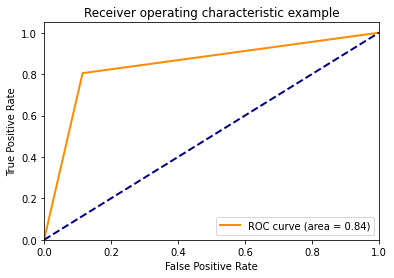

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

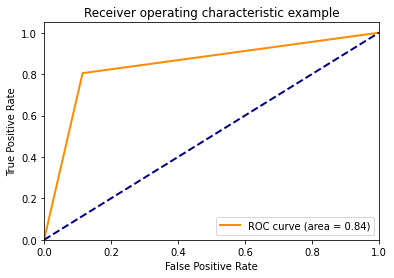

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
n_nodes = []
max_depths = []

for ind_tree in clf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 7
Average maximum depth 2


In [ ]:
# K fold cross validation
from sklearn.model_selection import cross_val_score
#X, y = make_blobs(n_samples=10000, n_features=10, centers=100,random_state=0)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(features, target, test_size=0.001, random_state=0)
clf = RandomForestClassifier(n_estimators=10, max_depth=None,
min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X_train_new, y_train_new, cv=5)
scores.mean()

0.9649512312477215

In [ ]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.9709172922306618

In [ ]:
LDA_transform = LDA(n_components=10)
LDA_transform.fit(features, labels)
features_new = LDA_transform.transform(features)

# Print the number of features
print('Original feature #:', features.shape[1])
print('Reduced feature #:', features_new.shape[1])

# Print the ratio of explained variance
print(LDA_transform.explained_variance_ratio_)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(features_new, labels, test_size=0.2, random_state=27)

clf_new = RandomForestClassifier()
clf_new.fit(X_train, y_train)
preds = clf_new.predict(X_val)
acc = accuracy_score(y_val, preds)
f1 = f1_score(y_val, preds)

print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
RSEED = 50

# Hyperparameter grid
# param_grid = {
#     'n_estimators': np.linspace(10, 200).astype(int),
#     'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
#     'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
#     'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
#     'min_samples_split': [2, 5, 10],
#     'bootstrap': [True, False]
# }

# # Estimator for use in random search
# estimator = RandomForestClassifier(random_state = RSEED)

# # Create the random search model
# rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = 'roc_auc', cv = 3, 
#                         n_iter = 10, verbose = 1, random_state=RSEED)

# # Fit 
# rs.fit(X_train, y_train)